<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

# Chargement des données

On télécharge un script depuis Github permettant de télécharger un fichier stocké sur GoogleDrive, puis on utilise ce script écrit en Python pour télécharger le fichier `bitcoin.zip`. Enfin, on décompresse les données pour obtenir le fichier `bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv` :

In [2]:
# Récupération des données au format .csv

!git clone https://github.com/chentinghao/download_google_drive.git
!python download_google_drive/download_gdrive.py "1FZsEdpBm-AQ2L9n_pMnm6336-O_IVo7z" "/content/bitcoin.zip"
!unzip bitcoin.zip

Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
100MB [00:01, 97.8MB/s] 
Archive:  bitcoin.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


Charge la série sous Pandas et affiche les informations du fichier :

In [3]:
# Création de la série sous Pandas
serie = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


# Pré-traitement des données

**1. Recherche des erreurs dans les données**

On commence par vérifier qu'il ne manque pas de dates. Pour cela, on vérifie qu'il y a bien 60 secondes entre deux Timestamp. Si on trouve un décalage non cohérent, on enregistre les informations dans une liste.

In [4]:
# Fonction permettant de vérifier si chaque intervalle est bien de 60s
def recherche_erreur(fenetre):
  if fenetre.values[1] - fenetre.values[0] != 60:
    Timestamp_Errors.append(fenetre.values)
  return 0

# Définit une liste pour sauvegarder le résultat des recherches
Timestamp_Errors = []

# Applique la fonction sur une fenêtre glissante des données
serie.Timestamp.rolling(2).apply(recherche_erreur)

0          NaN
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
4857372    0.0
4857373    0.0
4857374    0.0
4857375    0.0
4857376    0.0
Name: Timestamp, Length: 4857377, dtype: float64

On affiche les erreurs trouvées :

In [5]:
# Affiche les informations sur les erreurs trouvées

for erreur in Timestamp_Errors:
  print (pd.to_datetime(Timestamp_Errors[0],unit="s"))
  print((Timestamp_Errors[0][1] - Timestamp_Errors[0][0])/60 - 1)

DatetimeIndex(['2015-01-05 09:12:00', '2015-01-09 21:05:00'], dtype='datetime64[ns]', freq=None)
6472.0


On observe qu'il manque des données entre le 5 janvier 2015 à 9:12:00 et le 9 janvier 2015 à 21:05:00, soit 6472 données.

Recherchons maintenant le nombre de données manquantes :

In [6]:
# Affichage du nombre total de données manquantes

data_manquantes = sum(np.isnan(serie['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)

Nombre de données manquantes : 1243608


On a donc en tout : 6472 + 1243608 = 1250080 données manquantes.

**2. Identification des erreurs**

On convertit maintenant les `Timestamp` (mesure de temps exprimé en seconde écoulé depuis le 01/01/1970 - 00:00:00 UTC) en format plus standard :

In [7]:
# Conversion des timestamp en date
serie.Timestamp = pd.to_datetime(serie['Timestamp'], unit="s")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


On demande maintenant à échantillonner les données sur 60 secondes :

In [8]:
# Echantillonnage de la série sur 1min
serie_minute = serie.set_index('Timestamp').resample('60s').asfreq()

# Récupère le nombre de données sans valeurs numériques
data_manquantes = sum(np.isnan(serie_minute['Open']))

# Affiche le nombre de données manquantes et la série sur 1min 
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_minute

Nombre de données manquantes : 1250080


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


On obtient en tout 4863849 données après échantillonnage, soit (4863849-4857377) =  6472 données supplémentaires. Ceci est cohérent avec ce qu'on avait trouvé avant. Il manque 1250080 données. 

**3. Correction des données**

Pour corriger les données, on va tout simplement utiliser la fonction [fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) de Pandas avec la fonctionnalité de type `backfill` :

In [10]:
# Applique la fonction de remplissage automatique des données non numérique avec l'option backfill

serie_minute = serie_minute.fillna(method="backfill")

In [11]:
# Récupère le nombre de données non numériques et affiche les informations

data_manquantes = sum(np.isnan(serie_minute['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_minute

Nombre de données manquantes : 0


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


**4. Affichage des données**

Text(0.5, 1.0, 'Evolution du prix du BTC')

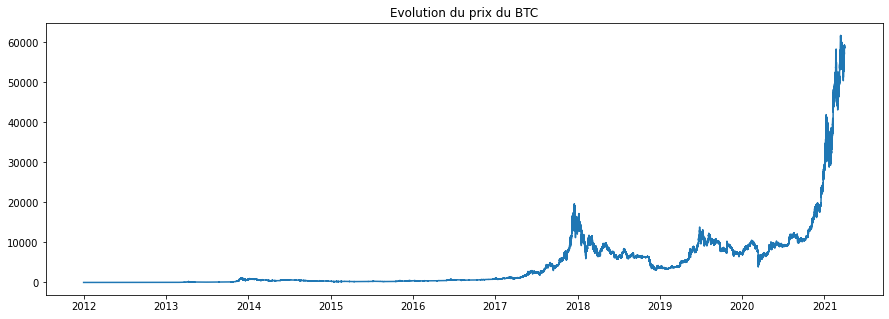

In [16]:
# Récupère les prix à l'ouverture et les index au format date
prix_ouverture = np.asarray(serie_minute.Open)
dates_ouverture = np.asarray(serie_minute.index)

# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(dates_ouverture, prix_ouverture)
plt.title("Evolution du prix du BTC")

# Préparation des données pour les prédictions

Nous allons réaliser des modélisations sur la série journalière, et pour une période allant du 1er avril 2013 au 31 mars 2021.

**1. Création de la série journalière**

On va réaliser des prédictions à l'aide d'une série à fréquence journalière. On commence par tenter d'estimer les données manquantes à l'aide d'une interpolation linéaire à l'aide de la fonction [interpolate](https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html#pandas.Series.interpolate) de Pandas, puis on complète avec la méthode `backfill` si nécessaire.

In [14]:
# Echantillonne la série sur 1 jour
serie_jour = serie.set_index('Timestamp').resample('1D').asfreq()

# Remplissage des données non numériques par interpolation linéraire
serie_jour = serie_jour.interpolate(method="slinear")

# Remplissage des données non numériques restantes par backfill
serie_jour = serie_jour.fillna(method="backfill")

# Affiche les informations
data_manquantes = sum(np.isnan(serie_jour['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_jour

Nombre de données manquantes : 0


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-01,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-02,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-03,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-04,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
...,...,...,...,...,...,...,...
2021-03-27,55081.26,55300.00,55081.26,55261.73,8.781130,484506.899450,55175.914921
2021-03-28,55817.85,55920.82,55807.12,55920.82,0.770004,43011.953916,55859.414172
2021-03-29,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695


Sauvegarde de l'évolution du prix sur l'intervalle d'étude dans un vecteur de type numpy :

In [81]:
# Définition des dates de début et de fin

date_debut = "2013-04-01 00:00:00"
date_fin = "2021-03-31 00:00:00"

# Sauvegarde du prix et des dates lors de l'ouverture des marchés dans un array numpy
prix_ouverture = np.asarray(serie_jour.loc[date_debut:date_fin].Open)
dates_ouverture = np.asarray(serie_jour.loc[date_debut:date_fin].index)

In [82]:
# Affiche la série

fig = px.line(x=dates_ouverture,y=prix_ouverture,title="Evolution du prix du BTC")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**2. Détection des anomalies dans la série "jour"**

Les anomalies sont fréquentes dans les séries temporelles, et la performance des prédictions est souvent améliorée lorsque ces anomalies sont traitées.  
Pour avoir un apperçu de ces éventuelles anomalies, nous allons utiliser la méthode ["Isolation Forest"](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) disponnible dans Scikit-learn.  

Les paramètres utilisés sont les suivants :
 - **n_estimators** : C'est le nombre de sous-groupes d'échantillons à utiliser. Une valeur de 128 ou 256 est préconnisée dans le document de recherche.
 - **max_samples** : C'est le nombre d'échantillons maximum à utiliser. Nous utiliserons l'ensemble des échantillons.
 - **max_features** :  C'est le nombre de motifs aléatoirement choisis sur chaque noeud de l'arbre. Nous choisirons un seul motif.
 - **contamination** : C'est le pourcentage estimé d'anomalies dans les données. Ce paramètre permet de régler la sensibilité de l'algorithme. On va commencer avec 5% et affiner si nécessaire par la suite.

In [99]:
# Initialise le modèle
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=256,max_samples=len(prix_ouverture), contamination=0.05,max_features=1, verbose=1)
clf.fit(np.reshape(prix_ouverture,newshape=(-1,1)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.05,
                max_features=1, max_samples=2922, n_estimators=256, n_jobs=None,
                random_state=None, verbose=1, warm_start=False)

In [100]:
# Réalise les prédictions
pred = clf.predict(np.reshape(prix_ouverture,newshape=(-1,1)))
pred

array([ 1,  1,  1, ..., -1, -1, -1])

On ajoute maintenant ces informations dans la série journalière et on affiche les informations :

In [142]:
# Ajoute une colonne "Anomalie" dans la série
serie_jour.loc[date_debut:date_fin,'Anomalies']=pred
serie_jour['Anomalies'] = serie_jour['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)
serie_jour.loc[date_debut:date_fin]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Anomalies
Timestamp,,,,,,,,
2013-04-01,99.525714,99.525714,99.525714,99.525714,0.155256,11.900373,99.525714,0
2013-04-02,103.730000,103.730000,103.730000,103.730000,0.014465,1.500435,103.730000,0
2013-04-03,116.000000,116.000000,116.000000,116.000000,31.713233,3678.735005,116.000000,0
2013-04-04,133.870000,134.540000,133.870000,134.540000,1.100634,147.497941,134.011742,0
2013-04-05,134.670000,134.670000,134.670000,134.670000,4.704580,633.565789,134.670000,0
...,...,...,...,...,...,...,...,...
2021-03-27,55081.260000,55300.000000,55081.260000,55261.730000,8.781130,484506.899450,55175.914921,1
2021-03-28,55817.850000,55920.820000,55807.120000,55920.820000,0.770004,43011.953916,55859.414172,1
2021-03-29,55790.280000,55822.980000,55777.980000,55804.360000,1.731449,96636.546983,55812.518695,1


In [143]:
# Affiche les informations sur les anomalies
print(serie_jour.loc[date_debut:date_fin]['Anomalies'].value_counts())

0    2775
1     147
Name: Anomalies, dtype: int64


**3. Affichage des anomalies sur le graphique**

In [168]:
# Récupère une tableau numpy comprenant les anomalies
anomalies = np.asarray(serie_jour.loc[date_debut:date_fin].Anomalies)

# Affiche la série

fig = px.line(x=dates_ouverture,y=prix_ouverture,title="Evolution du prix du BTC")
fig.add_trace(px.scatter(x=dates_ouverture,y=anomalies*prix_ouverture,color=anomalies.astype(np.bool)).data[0])

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(
       autorange = True,
       fixedrange= False
   )
fig.update_yaxes(yaxis)
fig.show()

Comme les anomalies détectées ne sembles pas cohérentes, nous n'allons pas les traiter...